# Import Libraries and Data

In [209]:
# Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from scipy.stats import ttest_ind, chi2_contingency
from tabulate import tabulate
from scipy.stats import levene, mannwhitneyu, shapiro


In [144]:
# Loading Dataset
raw_data = pd.read_csv("D:/Langara/DANA4800/Team Work 7/PHASE 1 - Clean Data Set Deliver/PHASE 1 - Clean Data Set Deliver/mimic_iv_Final.csv")
raw_data.head()

,subject_id,gender,age,mortality,ethnicity,Heart.Rate,Heart.rate.Alarm...High,Heart.Rate.Alarm...Low,SpO2.Desat.Limit,INR,...,Comb_DS,Fibrillation,PulmonaryDisease,Stroke,Hyperlipidemia,Dementia,AvgBloodPressureSystolic,AvgBloodPressureDiastolic,ConsolidatedRespiratoryRate,AvgHemoglobin
0,10004401,M,82,Death,WHITE,104,120,60,100.0,1.7,...,0,1,0,0,0,0,158.0,129.0,33.75,10.90
1,10005348,M,76,Alive,WHITE,103,160,85,88.0,1.3,...,0,1,0,0,1,0,147.5,75.0,22.75,11.90
2,10010058,M,80,Death,ASIAN - SOUTH EAST ASIAN,155,130,50,85.0,1.5,...,0,3,0,0,1,0,119.5,88.5,29.50,13.65
3,10013049,M,52,Alive,WHITE,91,120,50,85.0,1.6,...,0,0,0,0,0,0,130.0,70.0,15.50,14.25
4,10018423,M,37,Alive,WHITE,105,120,50,85.0,1.6,...,0,0,0,0,0,0,131.5,74.0,22.25,14.50


# Data Preparation

In [145]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406 entries, 0 to 3405
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   subject_id                   3406 non-null   int64  
 1   gender                       3406 non-null   object 
 2   age                          3406 non-null   int64  
 3   mortality                    3406 non-null   object 
 4   ethnicity                    3406 non-null   object 
 5   Heart.Rate                   3406 non-null   int64  
 6   Heart.rate.Alarm...High      3406 non-null   int64  
 7   Heart.Rate.Alarm...Low       3406 non-null   int64  
 8   SpO2.Desat.Limit             3406 non-null   float64
 9   INR                          3406 non-null   float64
 10  Prothrombin.time             3406 non-null   float64
 11  Anion.gap                    3406 non-null   int64  
 12  Creatinine..serum.           3406 non-null   float64
 13  Bicarbonate       

No missing values, all correct datatype, CHECK.

In [146]:
raw_data['mortality'].value_counts()

mortality
Alive    2916
Death     490
Name: count, dtype: int64

In [147]:
print(f"The data is unbalanced with {490/(490+2916)*100:.1f}% mortality rate.")

The data is unbalanced with 14.4% mortality rate.


In [148]:
# Convert Gender from Str to Numeric
raw_data['gender'] = pd.get_dummies(raw_data['gender'], drop_first = True)
# Convert Mortality from Str to Numeric
raw_data['mortality'] = pd.get_dummies(raw_data['mortality'], drop_first = True)

In [149]:
raw_data.columns

Index(['subject_id', 'gender', 'age', 'mortality', 'ethnicity', 'Heart.Rate',
       'Heart.rate.Alarm...High', 'Heart.Rate.Alarm...Low', 'SpO2.Desat.Limit',
       'INR', 'Prothrombin.time', 'Anion.gap', 'Creatinine..serum.',
       'Bicarbonate', 'Glucose..whole.blood.', 'GCS...Eye.Opening',
       'Hematocrit', 'Platelet.Count', 'Age.Group', 'Myocardial', 'Rupture',
       'Thrombosis', 'Systolic', 'Diastolic', 'Comb_DS', 'Fibrillation',
       'PulmonaryDisease', 'Stroke', 'Hyperlipidemia', 'Dementia',
       'AvgBloodPressureSystolic', 'AvgBloodPressureDiastolic',
       'ConsolidatedRespiratoryRate', 'AvgHemoglobin'],
      dtype='object')

In [150]:
features = ['Anion.gap', 'Heart.Rate', 'Creatinine..serum.', 'ConsolidatedRespiratoryRate', 'age', 'Hematocrit', 'Bicarbonate', 
            'AvgHemoglobin']

In [151]:
X = raw_data[features]
y = raw_data['mortality']

In [153]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [154]:
# Undersampling the training set
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

y_train_rus.value_counts()

mortality
False    331
True     331
Name: count, dtype: int64

In [155]:
#Undersampling the test set
rus = RandomUnderSampler(random_state=42)
X_test_rus, y_test_rus= rus.fit_resample(X_test, y_test)

y_test_rus.value_counts()

mortality
False    159
True     159
Name: count, dtype: int64

# Random Forest Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)[source]

## Untuned Model Performance

### Balanced Data - Undersampling technique

In [156]:
# Creating a Random Forest Model
rfc = RandomForestClassifier()

# Model Training
rfc_rus = rfc.fit(X_train_rus, y_train_rus)

# Get Prediction Values
y_pred_rus = rfc_rus.predict(X_test_rus)

print("Accuracy:",metrics.accuracy_score(y_test_rus, y_pred_rus))

Accuracy: 0.8113207547169812


In [157]:
# Get Prediction Values for the training set
y_pred_train = rfc_rus.predict(X_train_rus)

# Calculate accuracy
accuracy_train = metrics.accuracy_score(y_train_rus, y_pred_train)
print("Accuracy on Training Set:", accuracy_train)

Accuracy on Training Set: 1.0


## Grid Search

### Balanced Data

In [158]:
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [50, 100, 250, 500],
    "min_samples_split": range(2, 5),
    "min_samples_leaf": range(1, 4)
}

search_rus = GridSearchCV(rfc_rus, params, n_jobs = -1, cv = 10, verbose = 2)

search_rus.fit(X_train_rus, y_train_rus)

# GridSearchCV results
print("tuned hpyerparameters: (best parameters)", search_rus.best_params_)
print("accuracy :", search_rus.best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
tuned hpyerparameters: (best parameters) {'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 50}
accuracy : 0.79760289461782


In [159]:
# In case I lose the grid search results above
# fit the best hyperparameter in the data
search_rus = RandomForestClassifier(criterion = 'entropy', n_estimators = 250, min_samples_split = 2, min_samples_leaf = 1)
search_rus = search_rus.fit(X_train_rus, y_train_rus)

# Results from Best Models

In [160]:
y_prob = search_rus.predict_proba(X_test_rus)
y_prob_rus = search_rus.predict_proba(X_test_rus)

## 2. ROC Curves

In [161]:
# AUC score
rus_auc = roc_auc_score(y_test_rus, y_prob_rus[:,1])
print(f"For the best models: \nBalanced Data AUC = {rus_auc}")

For the best models: 
Balanced Data AUC = 0.8744116134646573


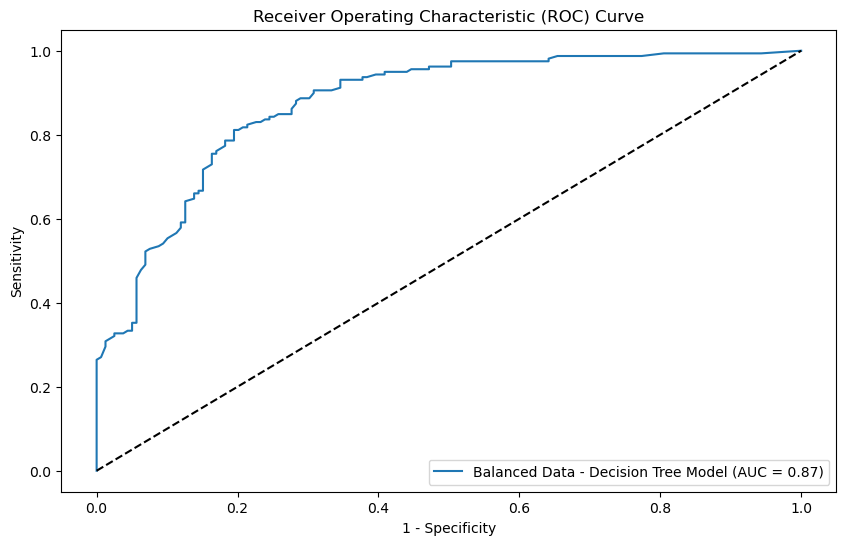

In [162]:
# fpr - false positive rate
# tpr - true positive rate
# threshold - part of the decision function used to calculate fpr and tpr

fpr_rus, tpr_rus, threshold_rus = roc_curve(y_test_rus, y_prob_rus[:,1])

plt.figure(figsize = (10, 6))
plt.plot(fpr_rus, tpr_rus, label = f'Balanced Data - Decision Tree Model (AUC = {rus_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random classifier
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

## 3. Classification Reports

In [163]:
y_pred_rus = search_rus.predict(X_test_rus)

In [164]:
print("Classification Report: Balanced Data & Uncalibrated")
print(classification_report(y_test_rus, y_pred_rus, target_names = ['Survival', 'Death']))

Classification Report: Balanced Data & Uncalibrated
              precision    recall  f1-score   support

    Survival       0.82      0.76      0.79       159
       Death       0.78      0.84      0.81       159

    accuracy                           0.80       318
   macro avg       0.80      0.80      0.80       318
weighted avg       0.80      0.80      0.80       318



## 4. Importance Graphs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


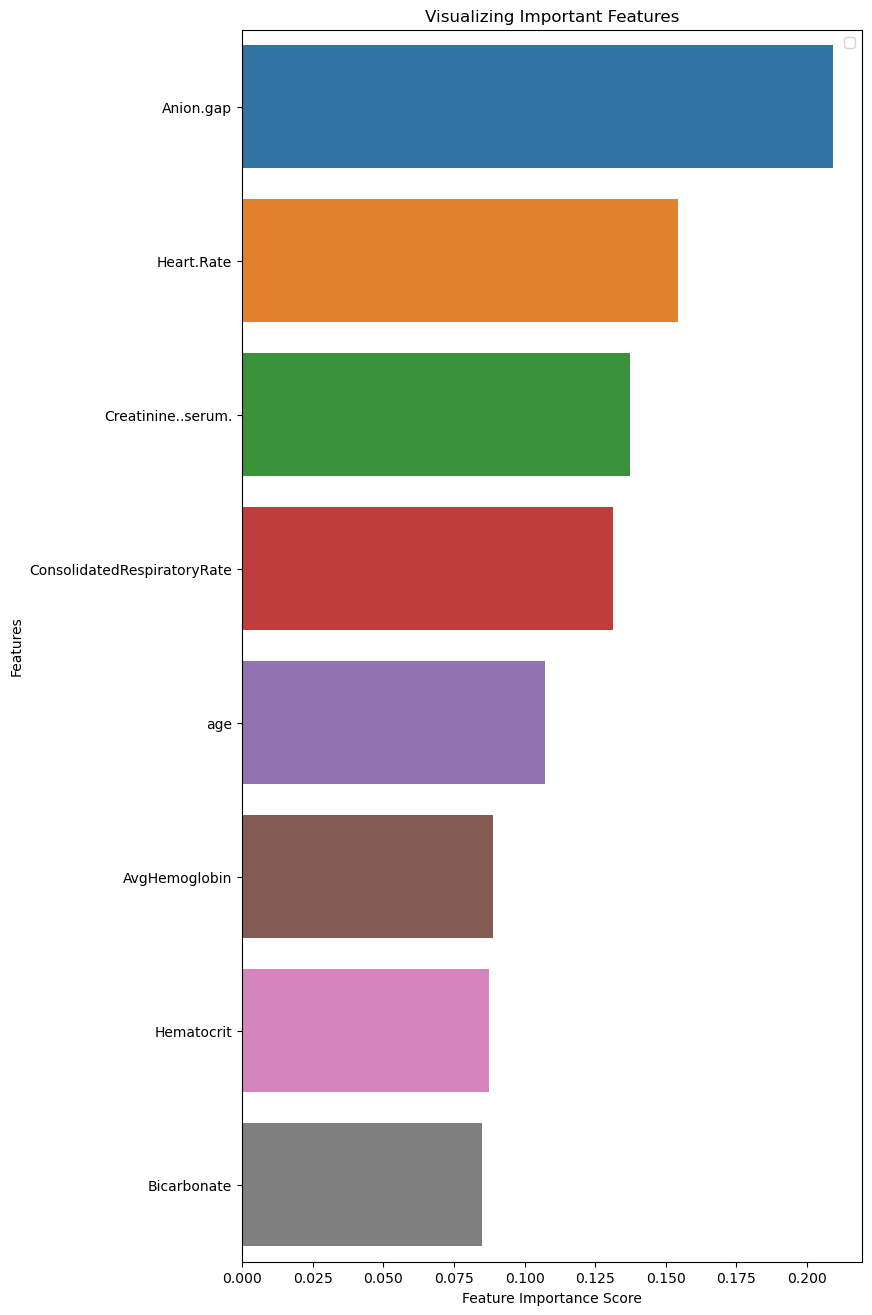

In [165]:
feature_imp = pd.Series(search_rus.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

plt.figure(figsize = (8, 16))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Error Analysis

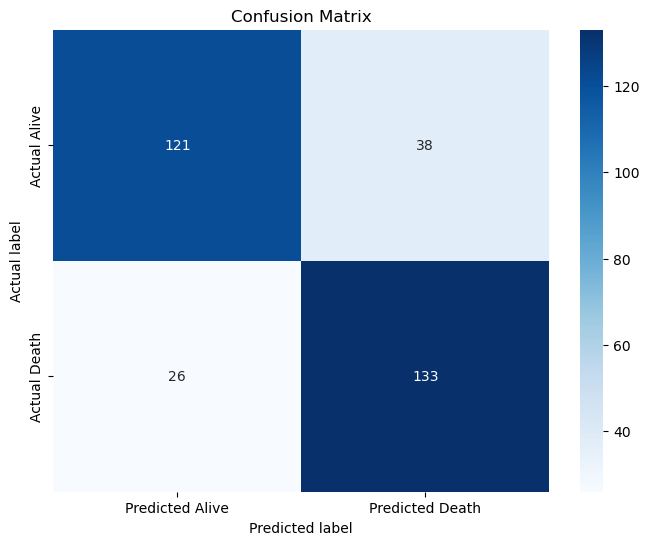

In [166]:
# Calculate confusion matrix
conf_matrix_rus  = confusion_matrix(y_test_rus, y_pred_rus)

# Convert confusion matrix to a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix_rus, index=['Actual Alive', 'Actual Death'], columns=['Predicted Alive', 'Predicted Death'])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')
plt.show()

1. "Actual Alive, Predicted Alive" (top-left) represents the number of cases where the model correctly predicted survival. - True Negative
2. "Actual Alive, Predicted Death" (top-right) represents the number of cases where the model incorrectly predicted death when the actual outcome was survival. - False Positive
3. "Actual Death, Predicted Alive" (bottom-left) represents the number of cases where the model incorrectly predicted survival when the actual outcome was death. - False Negative
4. "Actual Death, Predicted Death" (bottom-right) represents the number of cases where the model correctly predicted death. - True Positive

In [167]:
# Create a copy of the test dataset
test_data_with_labels = X_test_rus.copy()

# Add actual and predicted labels to the copy
test_data_with_labels['Actual_Label'] = y_test_rus.values
test_data_with_labels['Predicted_Label'] = y_pred_rus

# Display the test data with actual and predicted labels
print("Test Data with Actual and Predicted Labels:")
test_data_with_labels

Test Data with Actual and Predicted Labels:


,Anion.gap,Heart.Rate,Creatinine..serum.,ConsolidatedRespiratoryRate,age,Hematocrit,Bicarbonate,AvgHemoglobin,Actual_Label,Predicted_Label
2168,21,87,4.1,21.00,79,47.3,37,13.00,False,True
336,21,112,1.5,18.25,65,39.9,28,14.20,False,False
2355,12,84,1.1,30.00,84,30.0,26,9.70,False,False
1084,20,150,4.0,33.50,66,34.7,33,11.70,False,True
1473,12,98,1.0,26.50,53,42.5,27,13.70,False,False
...,...,...,...,...,...,...,...,...,...,...
373,18,99,1.5,26.25,89,33.3,26,9.65,True,True
2956,27,161,1.5,27.25,71,43.4,32,15.00,True,True
2825,24,119,3.0,27.00,69,32.1,29,9.40,True,True
2156,24,129,6.6,46.25,55,42.8,33,11.95,True,True


**Identify True Negative Cases**

In [168]:
# Filter true negative cases
true_negatives = test_data_with_labels[(test_data_with_labels['Actual_Label'] == 0) & (test_data_with_labels['Predicted_Label'] == 0)]
df_true_negatives = pd.DataFrame(true_negatives)
df_true_negatives

,Anion.gap,Heart.Rate,Creatinine..serum.,ConsolidatedRespiratoryRate,age,Hematocrit,Bicarbonate,AvgHemoglobin,Actual_Label,Predicted_Label
336,21,112,1.5,18.250000,65,39.9,28,14.20,False,False
2355,12,84,1.1,30.000000,84,30.0,26,9.70,False,False
1473,12,98,1.0,26.500000,53,42.5,27,13.70,False,False
621,12,98,0.8,22.750000,55,37.7,25,11.80,False,False
1698,16,140,2.9,33.250000,59,42.6,33,11.70,False,False
...,...,...,...,...,...,...,...,...,...,...
576,13,87,1.5,16.750000,70,42.8,32,16.30,False,False
1750,17,91,4.0,21.666667,64,35.7,32,10.75,False,False
2297,17,112,1.4,24.250000,55,44.8,37,14.20,False,False
501,10,108,1.2,26.500000,70,42.7,26,13.70,False,False


**Identify False Positive Cases**

In [169]:
# Filter false positive cases
false_positives = test_data_with_labels[(test_data_with_labels['Actual_Label'] == 0) & (test_data_with_labels['Predicted_Label'] == 1)]
df_false_positives = pd.DataFrame(false_positives)
df_false_positives

,Anion.gap,Heart.Rate,Creatinine..serum.,ConsolidatedRespiratoryRate,age,Hematocrit,Bicarbonate,AvgHemoglobin,Actual_Label,Predicted_Label
2168,21,87,4.1,21.00,79,47.3,37,13.00,False,True
1084,20,150,4.0,33.50,66,34.7,33,11.70,False,True
2645,21,130,2.7,34.75,51,42.7,27,11.85,False,True
2907,23,130,0.8,38.00,68,44.3,28,11.10,False,True
2400,22,168,6.6,30.50,55,49.1,35,17.60,False,True
2820,22,105,3.3,32.00,74,44.2,35,14.75,False,True
3388,26,138,1.6,25.00,56,36.5,36,10.95,False,True
1588,14,173,1.5,26.75,62,33.7,30,11.50,False,True
310,22,115,2.6,22.50,83,39.9,42,12.50,False,True
1407,20,104,3.6,35.00,78,31.5,28,11.00,False,True


**Identify False Negative Cases**

In [170]:
# Filter false negative cases
false_negatives = test_data_with_labels[(test_data_with_labels['Actual_Label'] == 1) & (test_data_with_labels['Predicted_Label'] == 0)]
df_false_negatives = pd.DataFrame(false_negatives)
df_false_negatives

,Anion.gap,Heart.Rate,Creatinine..serum.,ConsolidatedRespiratoryRate,age,Hematocrit,Bicarbonate,AvgHemoglobin,Actual_Label,Predicted_Label
2498,18,140,1.7,23.250000,79,40.9,35,11.55,True,False
2579,17,118,0.8,27.250000,68,38.9,29,11.80,True,False
1567,18,170,1.1,21.250000,50,41.7,32,14.80,True,False
1245,17,134,1.3,20.000000,74,48.4,35,11.10,True,False
2727,15,124,0.7,32.750000,65,40.3,36,13.10,True,False
1696,19,138,2.7,23.500000,82,43.3,34,13.00,True,False
2652,14,106,1.5,20.750000,69,42.0,27,12.65,True,False
1117,12,117,0.8,22.750000,79,36.7,27,12.65,True,False
1706,21,137,4.3,55.000000,65,42.6,42,14.40,True,False
2444,15,132,1.2,28.250000,77,50.1,29,14.85,True,False


**Identify True Positive Cases**

In [171]:
# Filter true positive cases
true_positives = test_data_with_labels[(test_data_with_labels['Actual_Label'] == 1) & (test_data_with_labels['Predicted_Label'] == 1)]
df_true_positives = pd.DataFrame(true_positives)
df_true_positives

,Anion.gap,Heart.Rate,Creatinine..serum.,ConsolidatedRespiratoryRate,age,Hematocrit,Bicarbonate,AvgHemoglobin,Actual_Label,Predicted_Label
3364,29,108,6.9,27.50,76,38.4,37,13.90,True,True
2884,14,136,2.0,28.00,91,46.7,28,15.45,True,True
1259,22,134,1.1,36.50,72,41.2,29,13.00,True,True
2429,23,118,3.9,44.50,78,39.9,31,14.10,True,True
2012,30,170,8.5,46.50,67,40.1,39,13.15,True,True
...,...,...,...,...,...,...,...,...,...,...
373,18,99,1.5,26.25,89,33.3,26,9.65,True,True
2956,27,161,1.5,27.25,71,43.4,32,15.00,True,True
2825,24,119,3.0,27.00,69,32.1,29,9.40,True,True
2156,24,129,6.6,46.25,55,42.8,33,11.95,True,True


**Statistical Tests**

In [172]:
numerical_features = ['Anion.gap', 'Heart.Rate', 'Creatinine..serum.', 'ConsolidatedRespiratoryRate', 'age', 'Hematocrit', 'Bicarbonate', 
            'AvgHemoglobin']

In [174]:
# # Plot boxplots for each feature
# for feature in numerical_features:
#     plt.figure(figsize=(8, 5))
#     plt.boxplot([true_positives[feature].astype(int), false_negatives[feature].astype(int),
#                  true_negatives[feature].astype(int), false_positives[feature].astype(int)], 
#                  labels=['True Positives', 'False Negatives', 'True Negatives', 'False Positives'])
#     plt.ylabel(feature)
#     plt.title(f'Box plot of {feature}')
#     plt.show()

**Boxplot of numerical features comparing False Negatives and True Positives** 

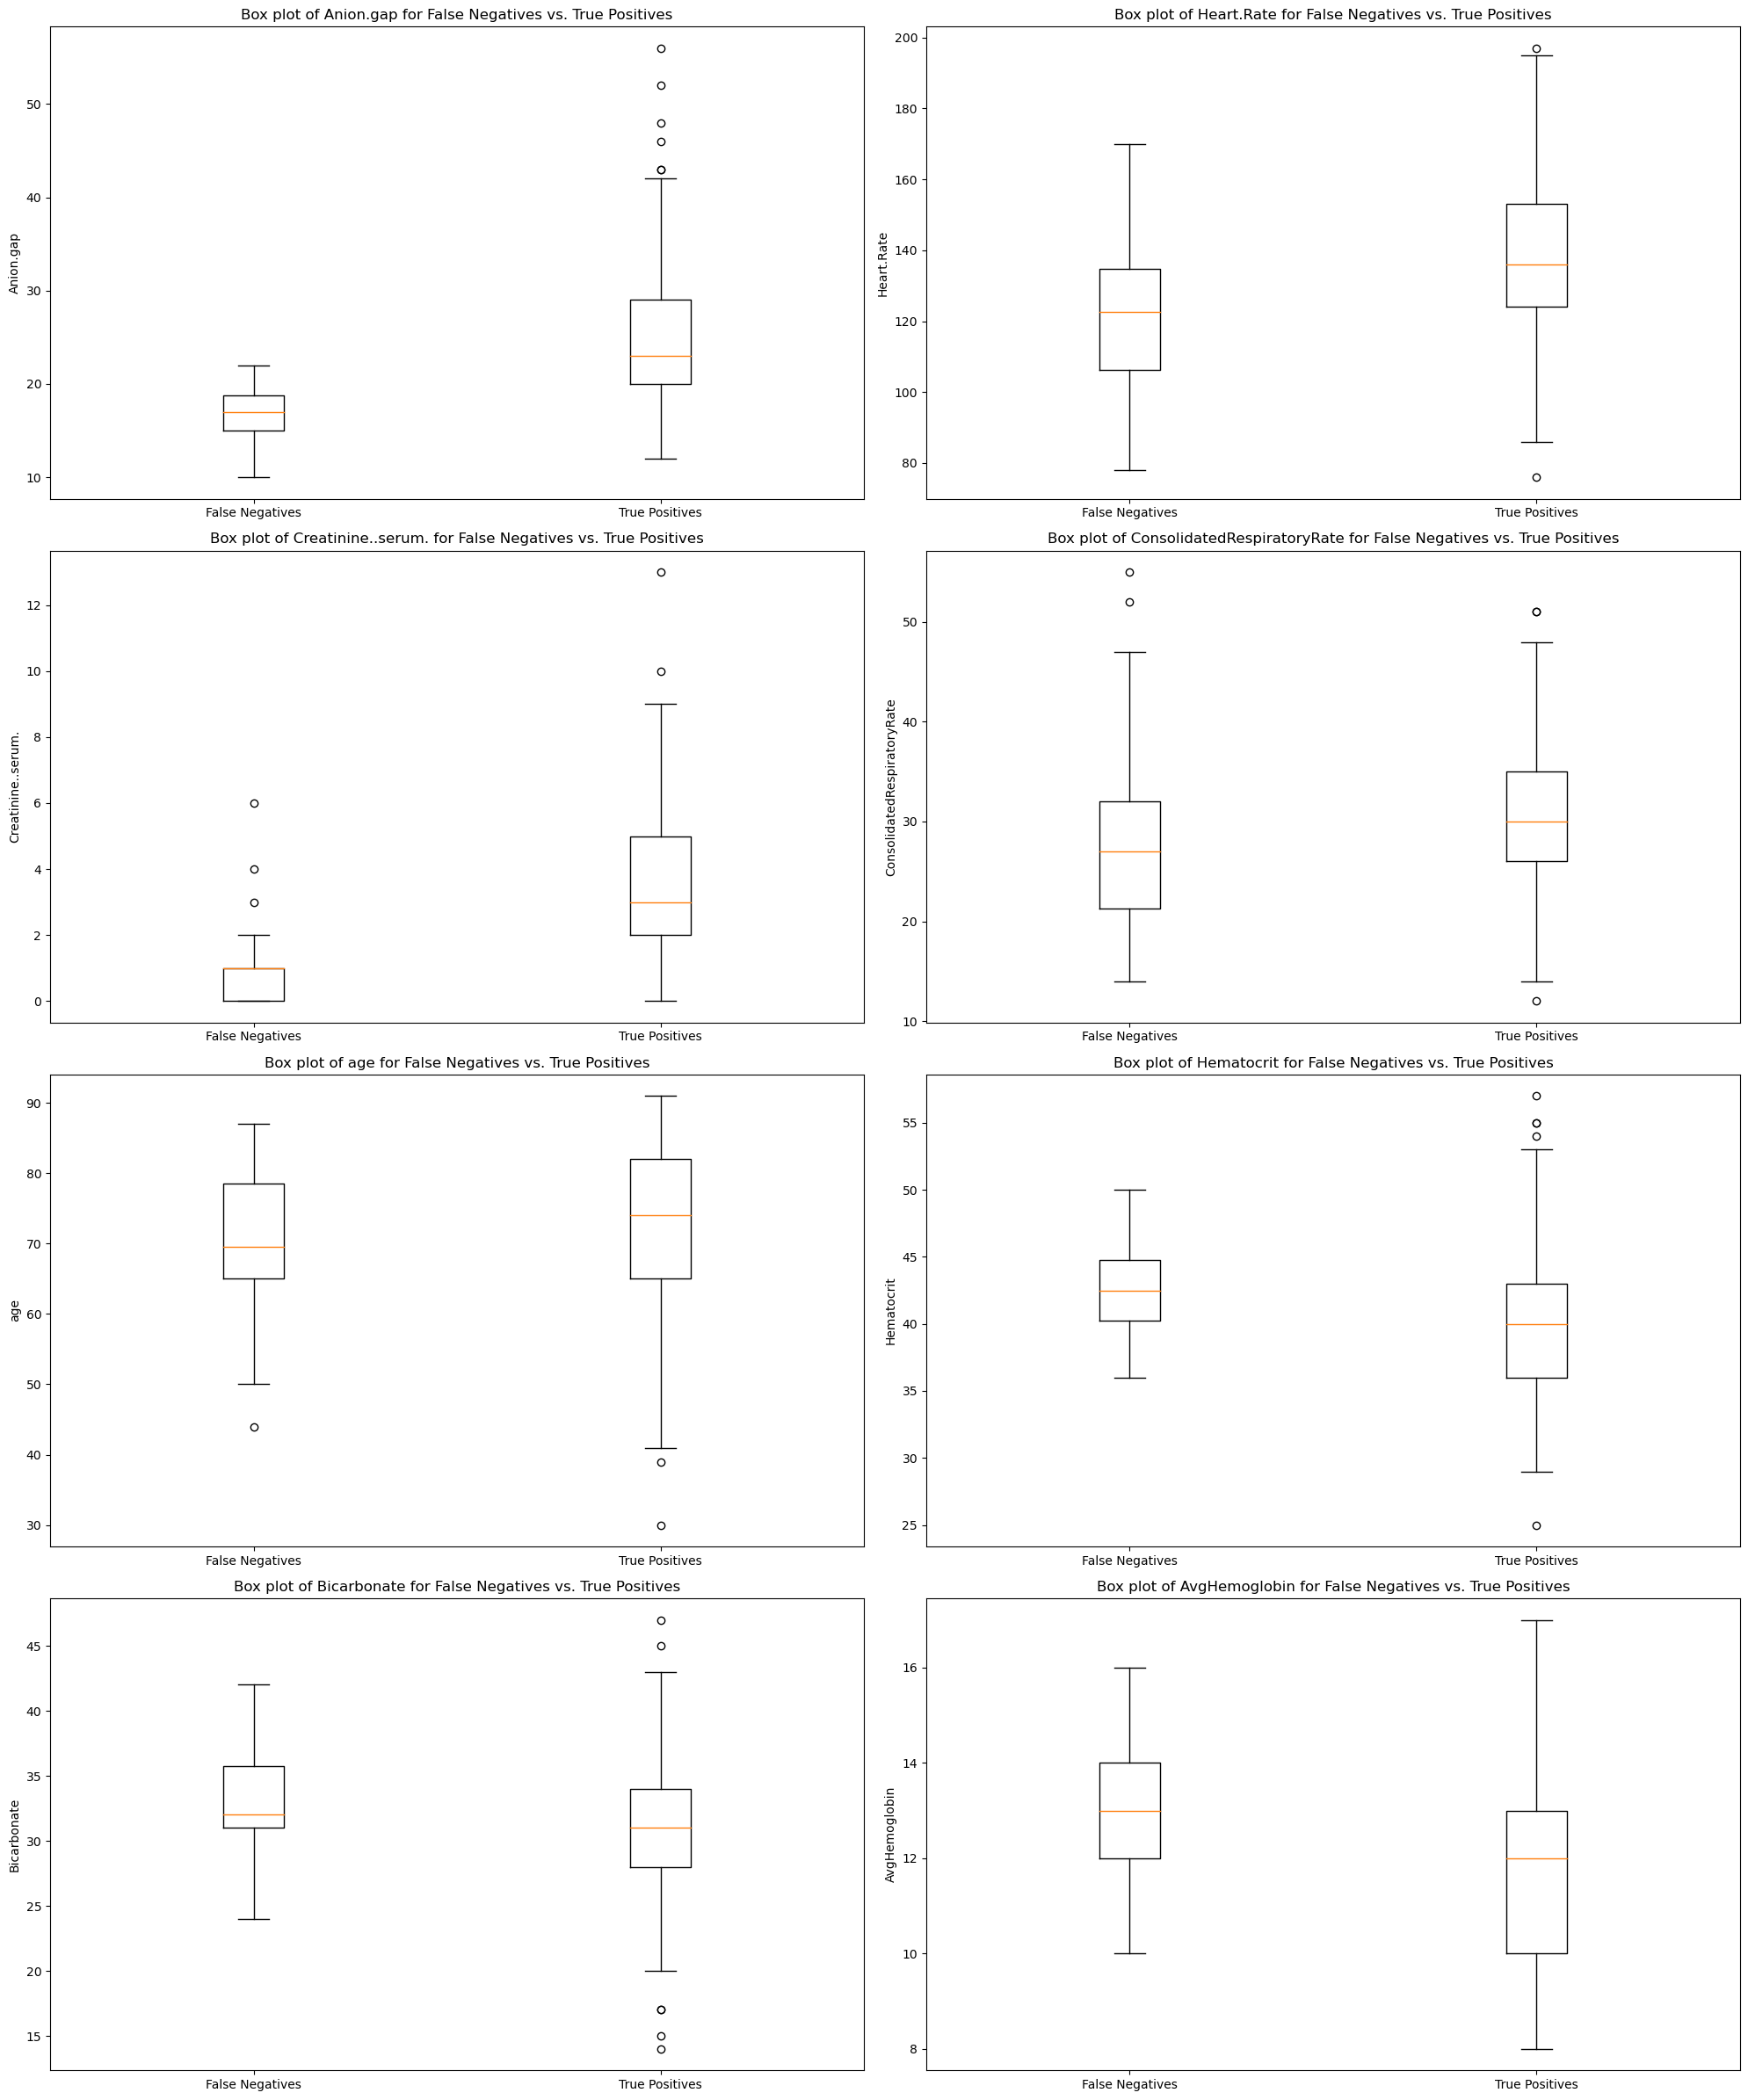

In [177]:
# Determine the number of rows needed
num_rows = len(numerical_features) // 2 + (len(numerical_features) % 2 > 0)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6*num_rows))

# Plot boxplots for each feature
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    axs[row, col].boxplot([false_negatives[feature].astype(int), true_positives[feature].astype(int)], labels=['False Negatives','True Positives'])
    axs[row, col].set_ylabel(feature)
    axs[row, col].set_title(f'Box plot of {feature} for False Negatives vs. True Positives')

# Adjust layout
plt.tight_layout()
plt.show()

Levene's Test

Levene's test is used to assess the equality of varinces in a set of samples. (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm#:~:text=Levene's%20test%20(%20Levene%201960)%20is,used%20to%20verify%20that%20assumption.) The null hypothesis of Levene's test is that the variances are equal across all groups. A low p-value (typically less than 0.05) indicates that there is enough evidence to reject the null hypothesis, suggesting that the variances are significantly different between the groups. If the p-value from Levene's test for a particular feature is less than 0.05, it would suggest that the variance of that feature is significantly different between the "True Positives" and "False Negatives" groups.

In [178]:
# Initialize an empty list to store p-values
p_values = []

# Calculate Levene's test p-value for each feature
for feature in numerical_features:
    if np.var(true_positives[feature]) == 0 or np.var(false_negatives[feature]) == 0:
        p_values.append({'Feature': feature, 'Levene p-value': 'NA'})
    else:
        levene_test = levene(false_negatives[feature], true_positives[feature])
        p_values.append({'Feature': feature, 'Levene p-value': levene_test.pvalue})

# Create a DataFrame from the list of p-values
p_values_df = pd.DataFrame(p_values)
p_values_df["Levene p-value"] = p_values_df["Levene p-value"].apply(lambda x: f"{x:.6f}" if x != 'NA' else x)
p_values_df

,Feature,Levene p-value
0,Anion.gap,0.005998
1,Heart.Rate,0.576464
2,Creatinine..serum.,0.003550
3,ConsolidatedRespiratoryRate,0.119547
4,age,0.379766
5,Hematocrit,0.029344
6,Bicarbonate,0.564741
7,AvgHemoglobin,0.102749


According to the Boxplot and Levene's p-value results for each numerical feature comparing the True Positives and False Negatives the Anion.gap, Creatinine..serum., Hematocrit features shows an unequal variance between the two groups. Therefore, we are gonna apply T-test for the equal variance features and Welch T-test for the unequal variance features.

In [179]:
numerical_features_eq = ['Heart.Rate', 'ConsolidatedRespiratoryRate', 'age', 'Bicarbonate', 'AvgHemoglobin']

numerical_features_ueq = ['Anion.gap', 'Creatinine..serum.','Hematocrit']

In the context of comparing two groups using t-tests, the null hypothesis (H0) states that there is no significant difference between the means of the two groups, while the alternative hypothesis (H1) suggests that there is a significant difference between the means of the two groups.

For the standard t-test applied to features with equal variances between false negatives and true positives:
- Null Hypothesis (H0): The mean value of the feature is the same for false negatives and true positives.
- Alternative Hypothesis (H1): The mean value of the feature is different between false negatives and true positives.

For the Welch's t-test applied to features with unequal variances between false negatives and true positives:
- Null Hypothesis (H0): The mean value of the feature is the same for false negatives and true positives.
- Alternative Hypothesis (H1): The mean value of the feature is different between false negatives and true positives.

For the standard t-test applied to features with equal variances between false positives and true negatives:
- Null Hypothesis (H0): The mean value of the feature is the same for false positives and true negatives.
- Alternative Hypothesis (H1): The mean value of the feature is different between false positives and true negatives.

For the Welch's t-test applied to features with unequal variances between false positives and true negatives:
- Null Hypothesis (H0): The mean value of the feature is the same for false positives and true negatives.
- Alternative Hypothesis (H1): The mean value of the feature is different between false positives and true negatives.

In simpler terms, these tests help us determine if there is a statistically significant difference in the average values of a feature between the two groups being compared (false negatives vs. true positives or false positives vs. true negatives). If the p-value associated with the test is below a certain threshold (e.g., 0.05), we reject the null hypothesis and conclude that there is indeed a significant difference in the means of the groups. Otherwise, we fail to reject the null hypothesis, suggesting that there is no significant difference.

In [180]:
results_false_negatives_eq = []
# Perform t-tests for each numerical feature
for feature in numerical_features_eq:
    false_neg_feature = false_negatives[feature]
    true_pos_feature = true_positives[feature]
    
    t_stat, p_value = ttest_ind(false_neg_feature, true_pos_feature, equal_var=True)
    results_false_negatives_eq.append([feature, t_stat, p_value])

results_false_negatives_df = pd.DataFrame(results_false_negatives_eq, columns=["Feature", "t-statistic", "p-value"])
# Format p-values
results_false_negatives_df["p-value"] = results_false_negatives_df["p-value"].apply(lambda x: f"{x:.6f}")

results_false_negatives_df

,Feature,t-statistic,p-value
0,Heart.Rate,-3.274338,0.001303
1,ConsolidatedRespiratoryRate,-1.303191,0.194418
2,age,-1.233776,0.219130
3,Bicarbonate,2.138328,0.034037
4,AvgHemoglobin,2.724327,0.007174


In [181]:
results_false_negatives_ueq = []
# Perform t-tests for each numerical feature
for feature in numerical_features_ueq:
    false_neg_feature = false_negatives[feature]
    true_pos_feature = true_positives[feature]
    
    t_stat, p_value = ttest_ind(false_neg_feature, true_pos_feature, equal_var=False)
    results_false_negatives_ueq.append([feature, t_stat, p_value])

results_false_negatives_df = pd.DataFrame(results_false_negatives_ueq, columns=["Feature", "t-statistic", "p-value"])
# Format p-values
results_false_negatives_df["p-value"] = results_false_negatives_df["p-value"].apply(lambda x: f"{x:.16f}")

results_false_negatives_df

,Feature,t-statistic,p-value
0,Anion.gap,-9.750989,0.0000000000000002
1,Creatinine..serum.,-6.868052,0.0000000048065342
2,Hematocrit,3.182160,0.0024604364786119


Based on the result, the main factors contributing to false negatives are **Anion.gap, Creatinine..serum., Hematocrit, Heart Rate, AvgHemoglobin and Bicarbonate**. 

In [182]:
important_features_fn = ['Anion.gap', 'Creatinine..serum.', 'Hematocrit', 'Heart.Rate', 'AvgHemoglobin', 'Bicarbonate']

Here, we are gonna create plots comparing the distribution of the selected features between two groups: False negatives and True positives. These plots are useful to understand how the selected features behave differently between false negatives and true positives, which can provide insights into factors contributing to classification errors in the model.

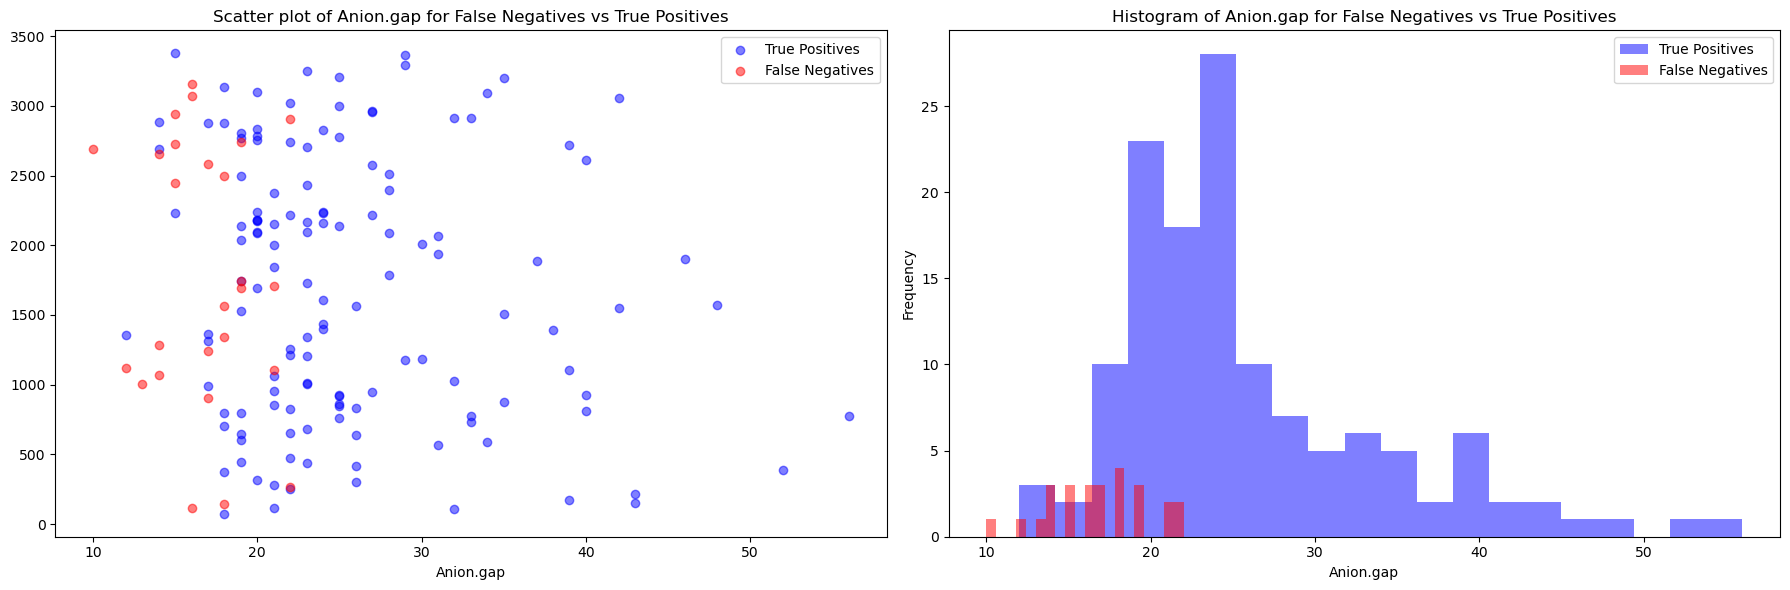

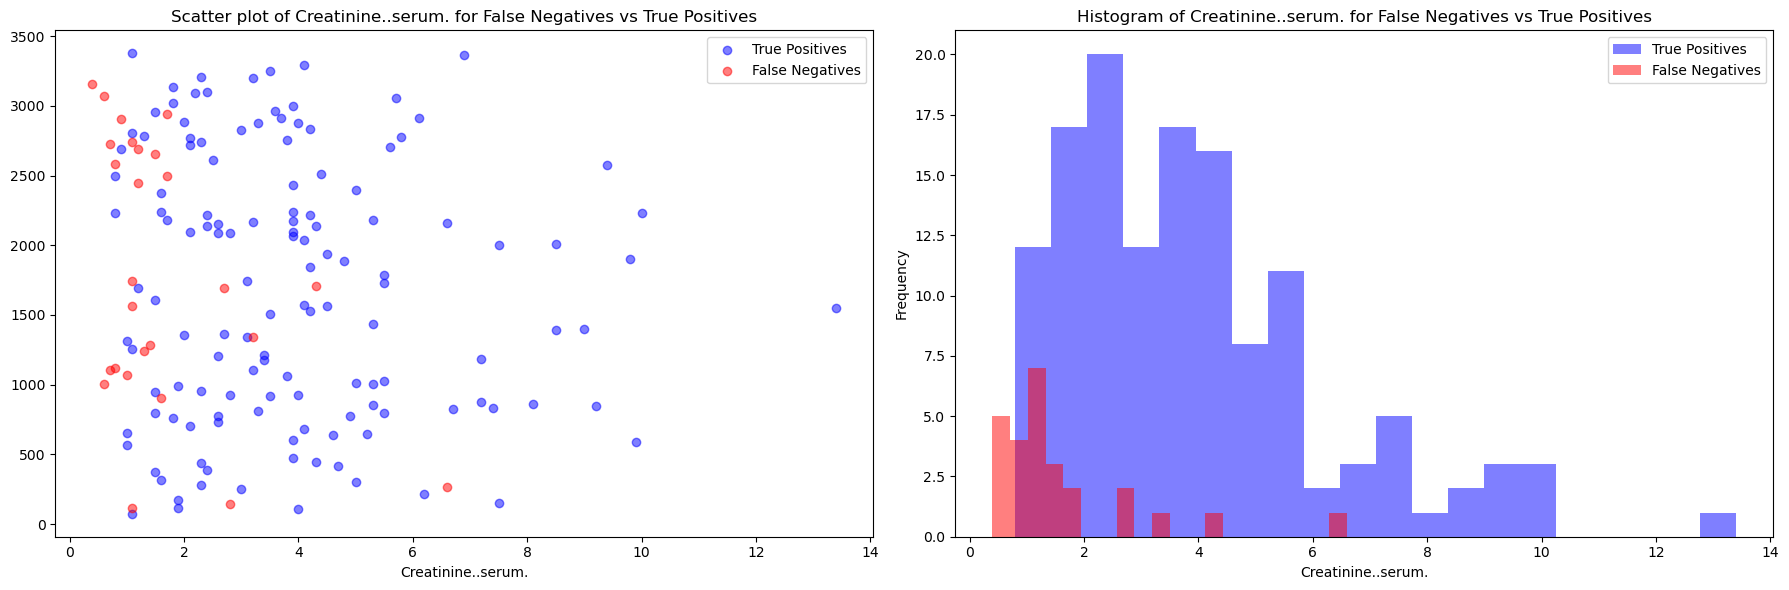

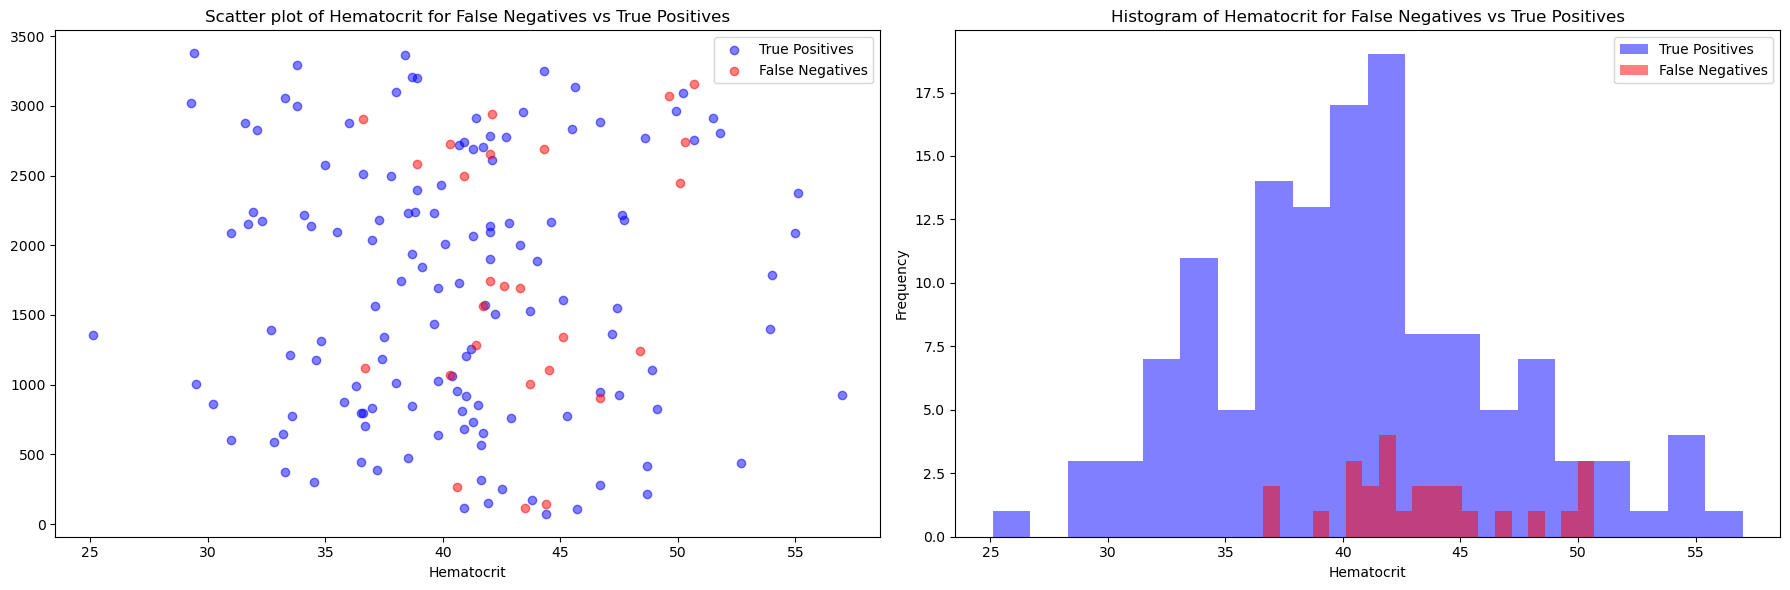

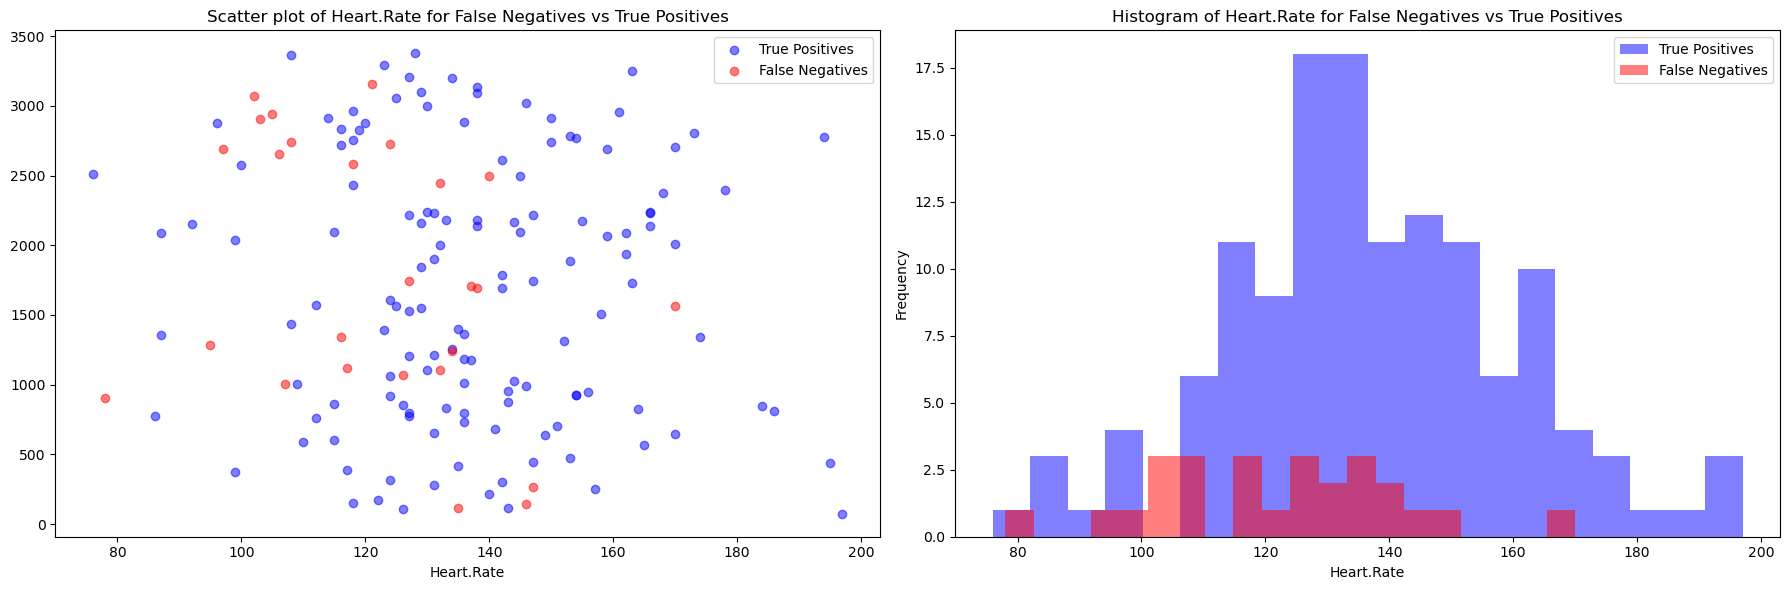

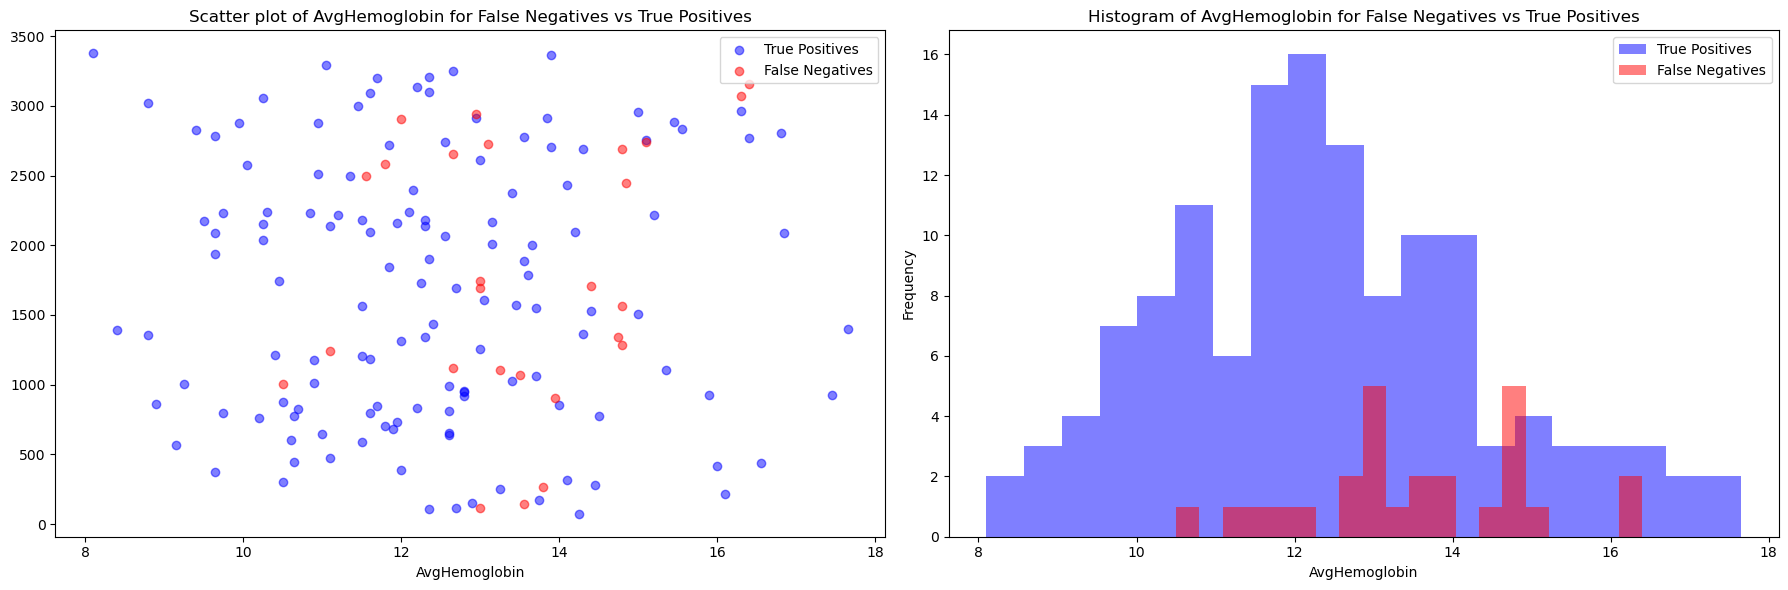

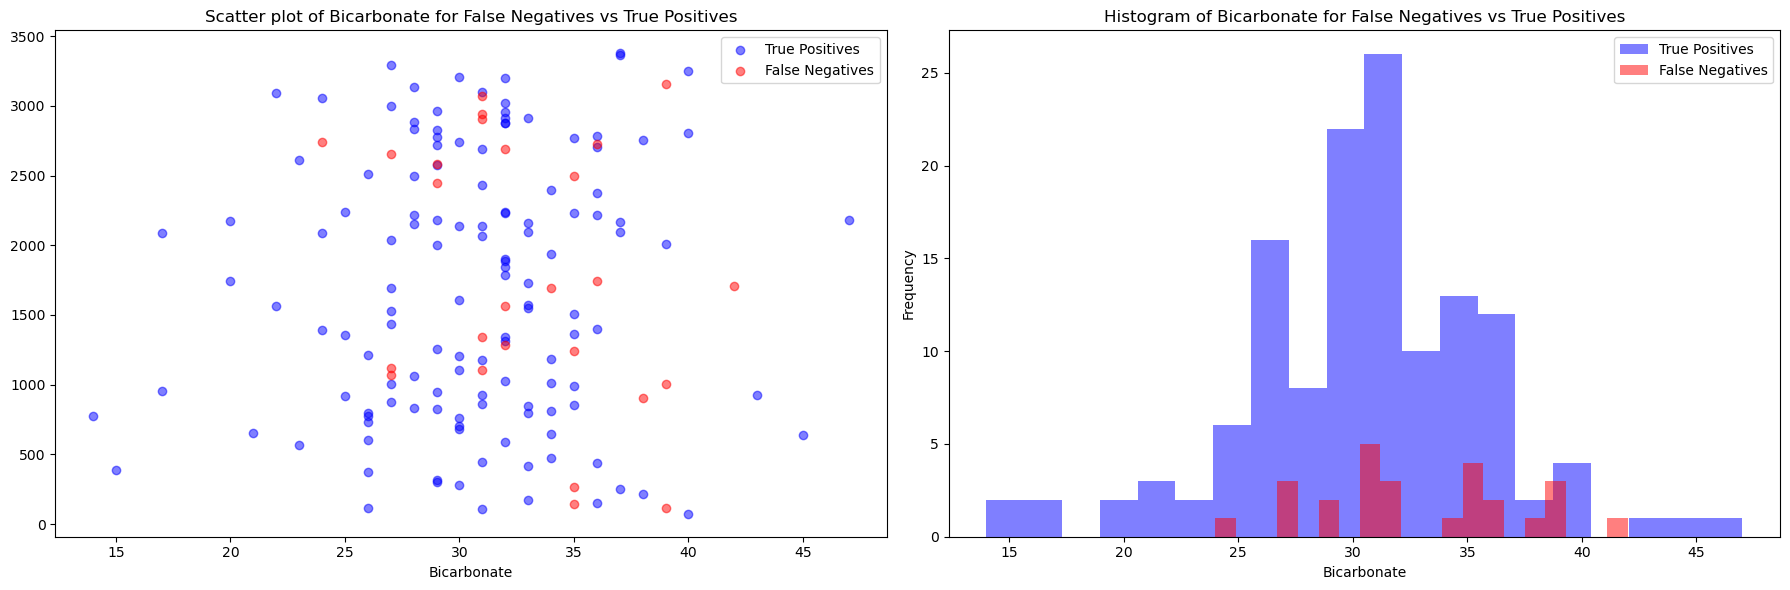

In [184]:
# Display results for each feature in a single row
for feature in important_features_fn:
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Scatter plot
    axs[0].scatter(true_positives[feature], true_positives.index, c='blue', label='True Positives', alpha=0.5)
    axs[0].scatter(false_negatives[feature],  false_negatives.index, c='red', label='False Negatives', alpha=0.5)
    axs[0].set_xlabel(feature)
    axs[0].set_title(f'Scatter plot of {feature} for False Negatives vs True Positives')
    axs[0].legend()

    # Histogram
    axs[1].hist(true_positives[feature], bins=20, color='blue', alpha=0.5, label='True Positives')
    axs[1].hist(false_negatives[feature], bins=20, color='red', alpha=0.5, label='False Negatives')
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(f'Histogram of {feature} for False Negatives vs True Positives')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

**Boxplots of numerical variables comparing False Positives and True Negatives**

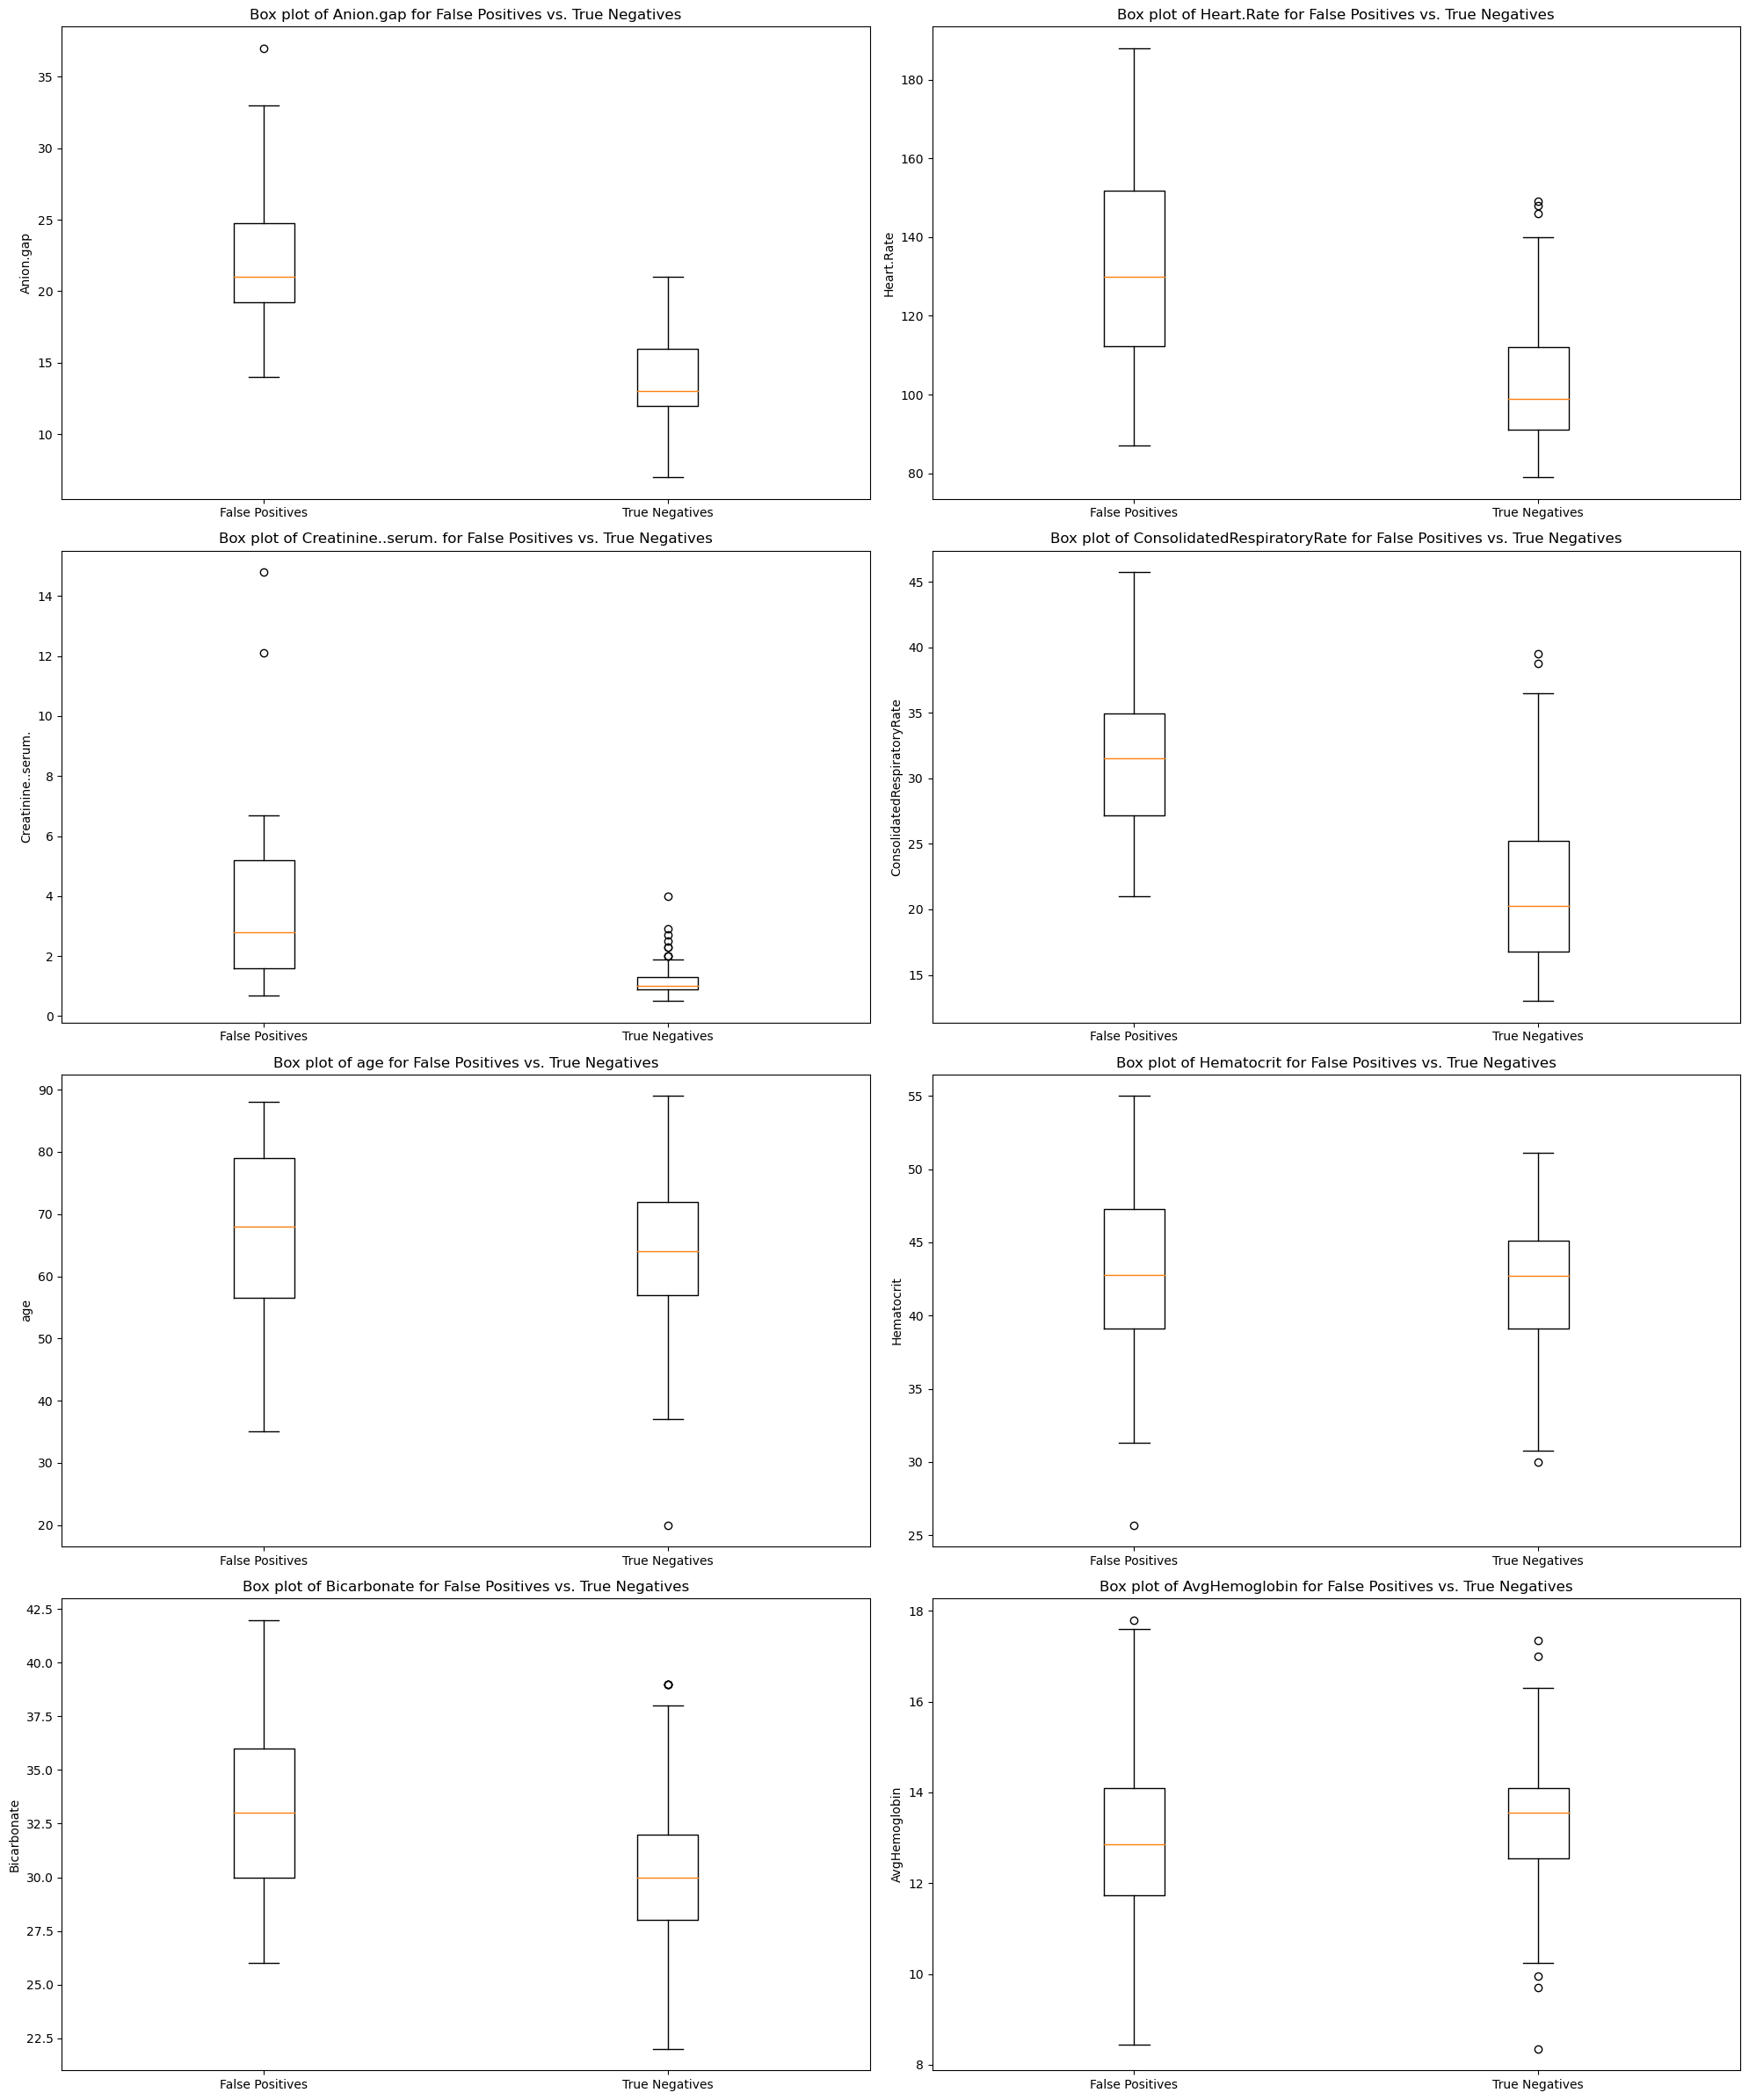

In [186]:
# Determine the number of rows needed
num_rows = len(numerical_features) // 2 + (len(numerical_features) % 2 > 0)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6*num_rows))

# Plot boxplots for each feature
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    axs[row, col].boxplot([false_positives[feature], true_negatives[feature]], labels=['False Positives', 'True Negatives'])
    axs[row, col].set_ylabel(feature)
    axs[row, col].set_title(f'Box plot of {feature} for False Positives vs. True Negatives')

# Adjust layout
plt.tight_layout()
plt.show()

Levene's Test

In [187]:
# Initialize an empty list to store p-values
p_values = []

# Calculate Levene's test p-value for each feature
for feature in numerical_features:
    if np.var(true_negatives[feature]) == 0 or np.var(false_positives[feature]) == 0:
        p_values.append({'Feature': feature, 'Levene p-value': 'NA'})
    else:
        levene_test = levene(false_positives[feature], true_negatives[feature])
        p_values.append({'Feature': feature, 'Levene p-value': levene_test.pvalue})

# Create a DataFrame from the list of p-values
p_values_df = pd.DataFrame(p_values)
p_values_df["Levene p-value"] = p_values_df["Levene p-value"].apply(lambda x: f"{x:.6f}" if x != 'NA' else x)
p_values_df

,Feature,Levene p-value
0,Anion.gap,0.008248
1,Heart.Rate,0.004604
2,Creatinine..serum.,0.000000
3,ConsolidatedRespiratoryRate,0.970690
4,age,0.085008
5,Hematocrit,0.004165
6,Bicarbonate,0.019345
7,AvgHemoglobin,0.006733


According to the Boxplot and Levene's p-value results for each numerical feature comparing the False Positives and True Negatives the Anion.gap, Heart.Rate, Creatinine..serum., Hematocrit, Bicarbonate, AvgHemoglobin features shows an unequal variance between the two groups. Therefore, we are gonna apply T-test for the equal variance features and Welch T-test for the unequal variance features.

In [188]:
numerical_features_eq = ['ConsolidatedRespiratoryRate', 'age']

numerical_features_ueq = ['Anion.gap', 'Heart.Rate', 'Creatinine..serum.', 'Hematocrit', 'Bicarbonate', 'AvgHemoglobin']

Standard T-test

In [189]:
results_false_positives_eq = []
# Perform t-tests for each numerical feature
for feature in numerical_features_eq:
    false_pos_feature = false_positives[feature]
    true_neg_feature = true_negatives[feature]

    t_stat, p_value = ttest_ind(false_pos_feature, true_neg_feature, equal_var=True)
    results_false_positives_eq.append([feature, t_stat, p_value])

results_false_positives_df = pd.DataFrame(results_false_positives_eq, columns=["Feature", "t-statistic", "p-value"])
results_false_positives_df["p-value"] = results_false_positives_df["p-value"].apply(lambda x: f"{x:.6f}")
results_false_positives_df

,Feature,t-statistic,p-value
0,ConsolidatedRespiratoryRate,8.687275,0.000000
1,age,1.573730,0.117563


Welch T-test

In [190]:
results_false_positives_ueq = []
# Perform t-tests for each numerical feature
for feature in numerical_features_ueq:
    false_pos_feature = false_positives[feature]
    true_neg_feature = true_negatives[feature]

    t_stat, p_value = ttest_ind(false_pos_feature, true_neg_feature, equal_var=False)
    results_false_positives_ueq.append([feature, t_stat, p_value])

results_false_positives_df = pd.DataFrame(results_false_positives_ueq, columns=["Feature", "t-statistic", "p-value"])
results_false_positives_df["p-value"] = results_false_positives_df["p-value"].apply(lambda x: f"{x:.6f}")
results_false_positives_df

,Feature,t-statistic,p-value
0,Anion.gap,9.023594,0.000000
1,Heart.Rate,7.258805,0.000000
2,Creatinine..serum.,5.131951,0.000009
3,Hematocrit,0.530116,0.598527
4,Bicarbonate,3.416710,0.001239
5,AvgHemoglobin,-0.725452,0.471778


Based on the result, the main factors contributing to false positives are **Anion.gap, Heart.Rate, RespiratoryRate, Creatinine..serum. and Bicarbonate**

In [191]:
important_features_fp = ['Anion.gap', 'Heart.Rate', 'ConsolidatedRespiratoryRate', 'Creatinine..serum.', 'Bicarbonate']

Here, we are gonna create plots comparing the distribution of the selected features between two groups: False postives and True negatives. These plots are useful to understand how the selected features behave differently between false positives and true negatives, which can provide insights into factors contributing to classification errors in the model.

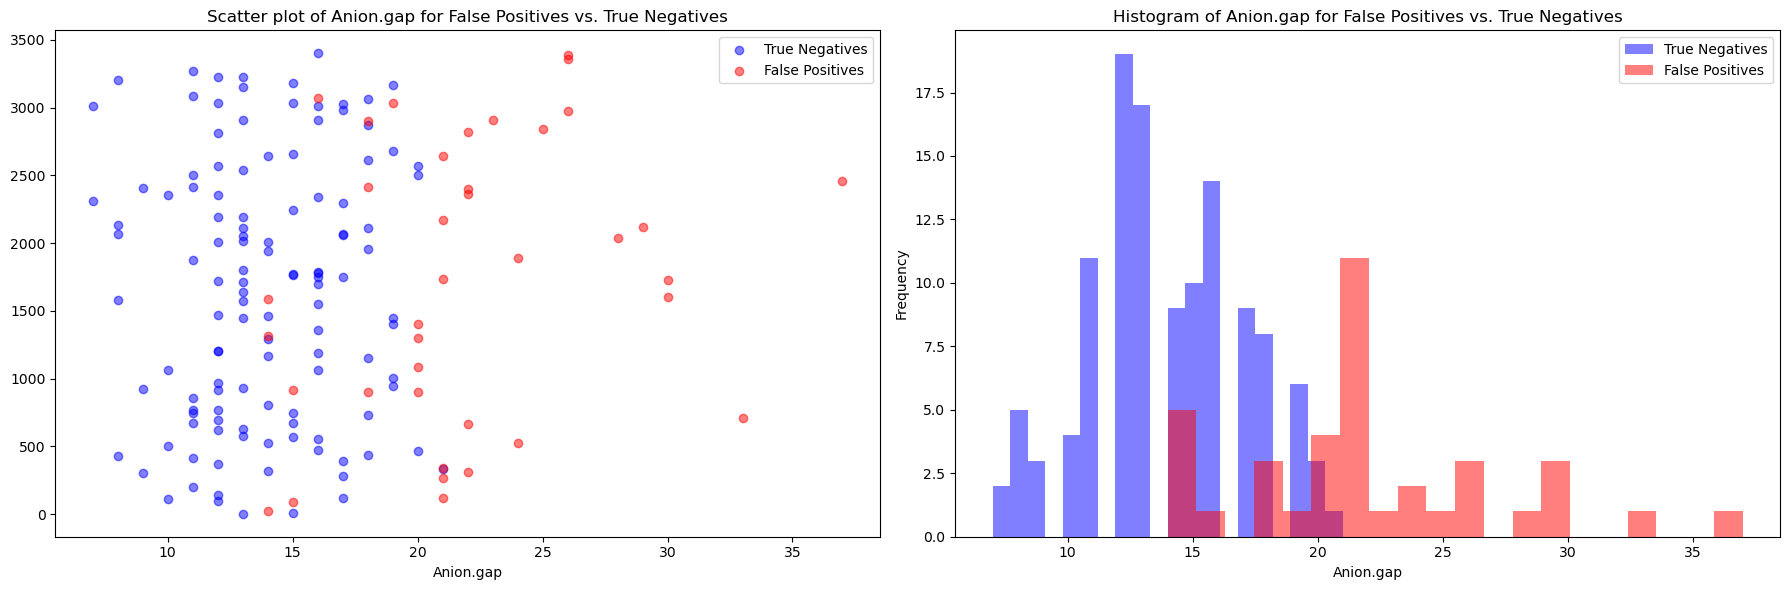

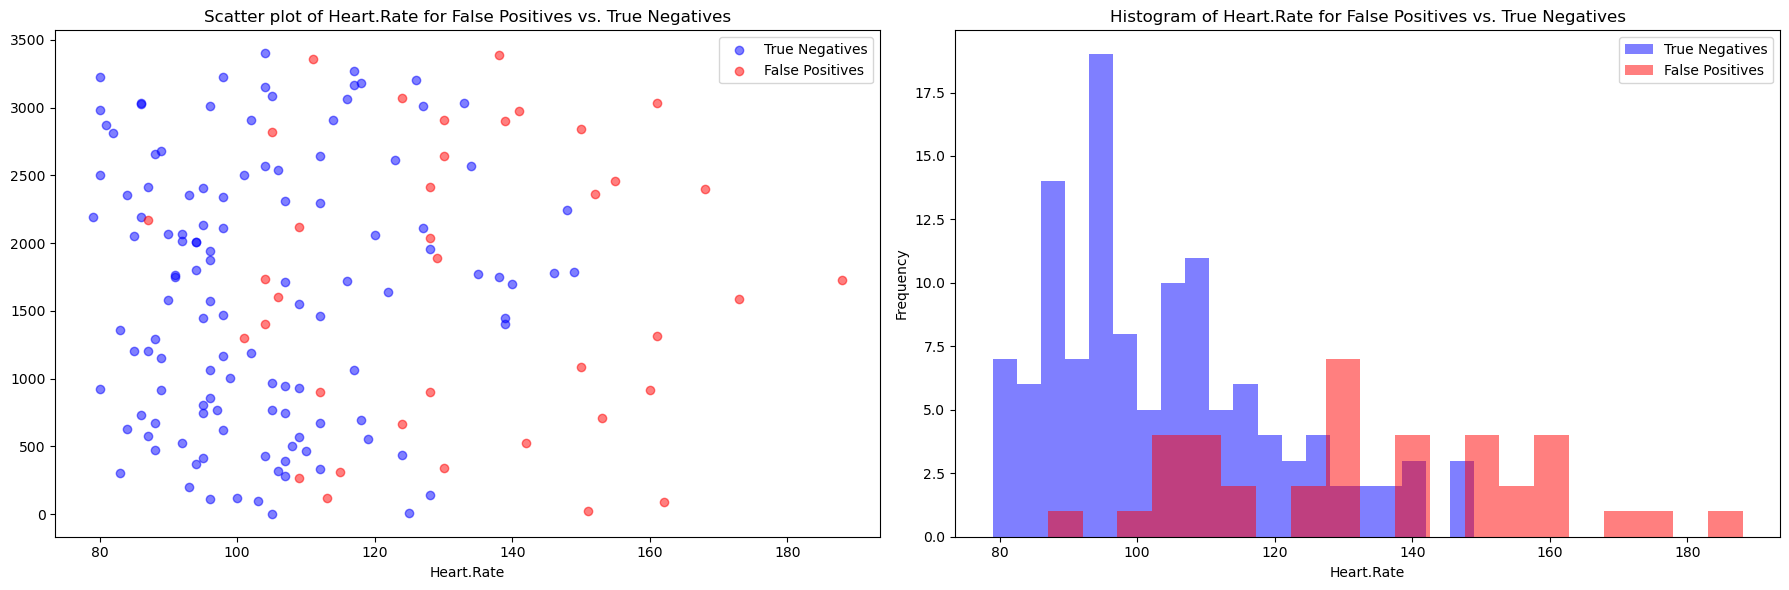

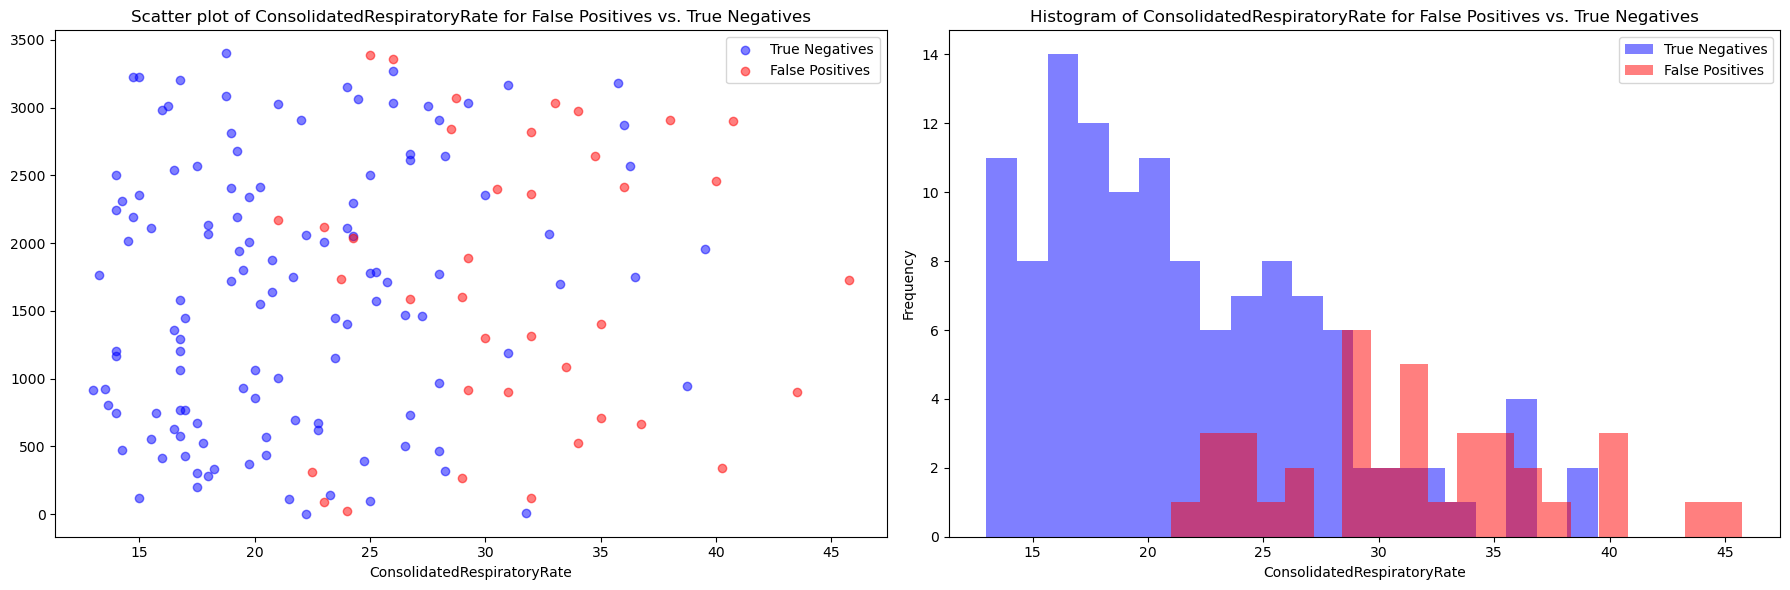

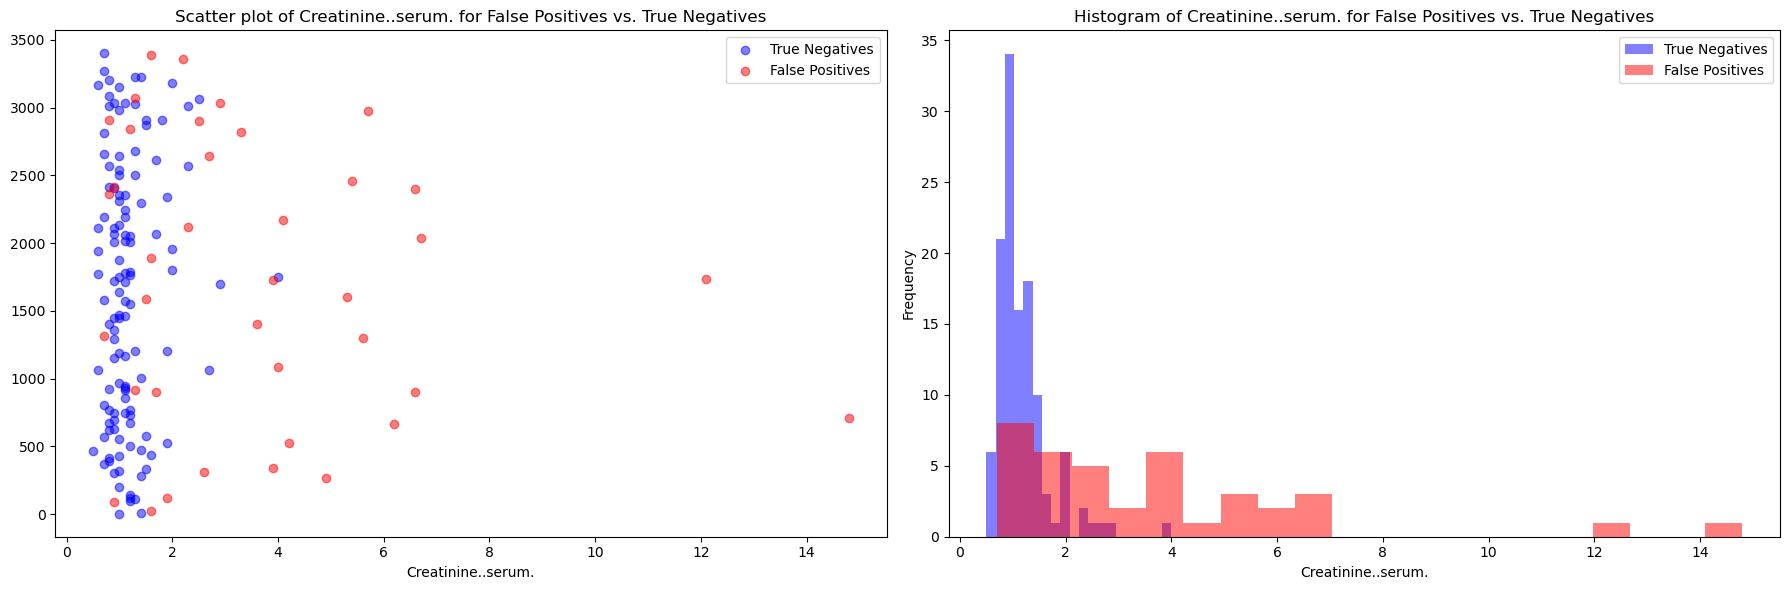

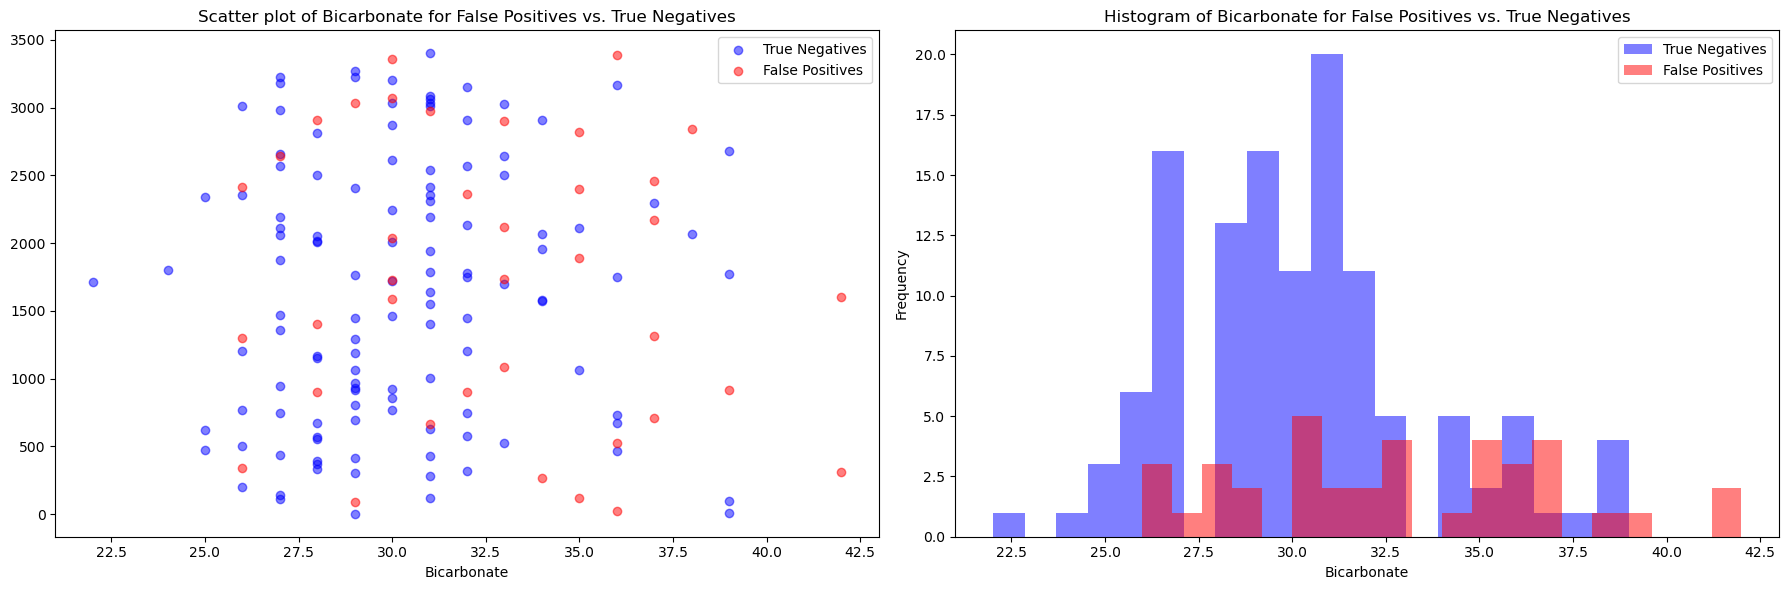

In [192]:
# Display results for each feature in a single row
for feature in important_features_fp:
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Scatter plot
    axs[0].scatter(true_negatives[feature], true_negatives.index, c='blue', label='True Negatives', alpha=0.5)
    axs[0].scatter(false_positives[feature], false_positives.index, c='red', label='False Positives', alpha=0.5)
    axs[0].set_xlabel(feature)
    axs[0].set_title(f'Scatter plot of {feature} for False Positives vs. True Negatives')
    axs[0].legend()

    # Histogram
    axs[1].hist(true_negatives[feature], bins=20, color='blue', alpha=0.5, label='True Negatives')
    axs[1].hist(false_positives[feature], bins=20, color='red', alpha=0.5, label='False Positives')
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(f'Histogram of {feature} for False Positives vs. True Negatives')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

Therefore analysing the statistical test results we can conclude that the factors contributing to the,
* False Negatives: Anion.gap, Creatinine..serum., Hematocrit, Heart Rate, AvgHemoglobin and Bicarbonate
* False Positives: Anion.gap, Heart.Rate, RespiratoryRate, Creatinine..serum. and Bicarbonate

The common features/factors contribute to the false negatives and false positives are Anion.gap, Creatinine..serum., Heart.Rate and Bicarbonate. And the other individual factors contribute to result error predictions are Hematocrit, Hemoglobin and Respiratory rate. In order to see the distribution of these factors we are gonna add distribution curve to the histogram.

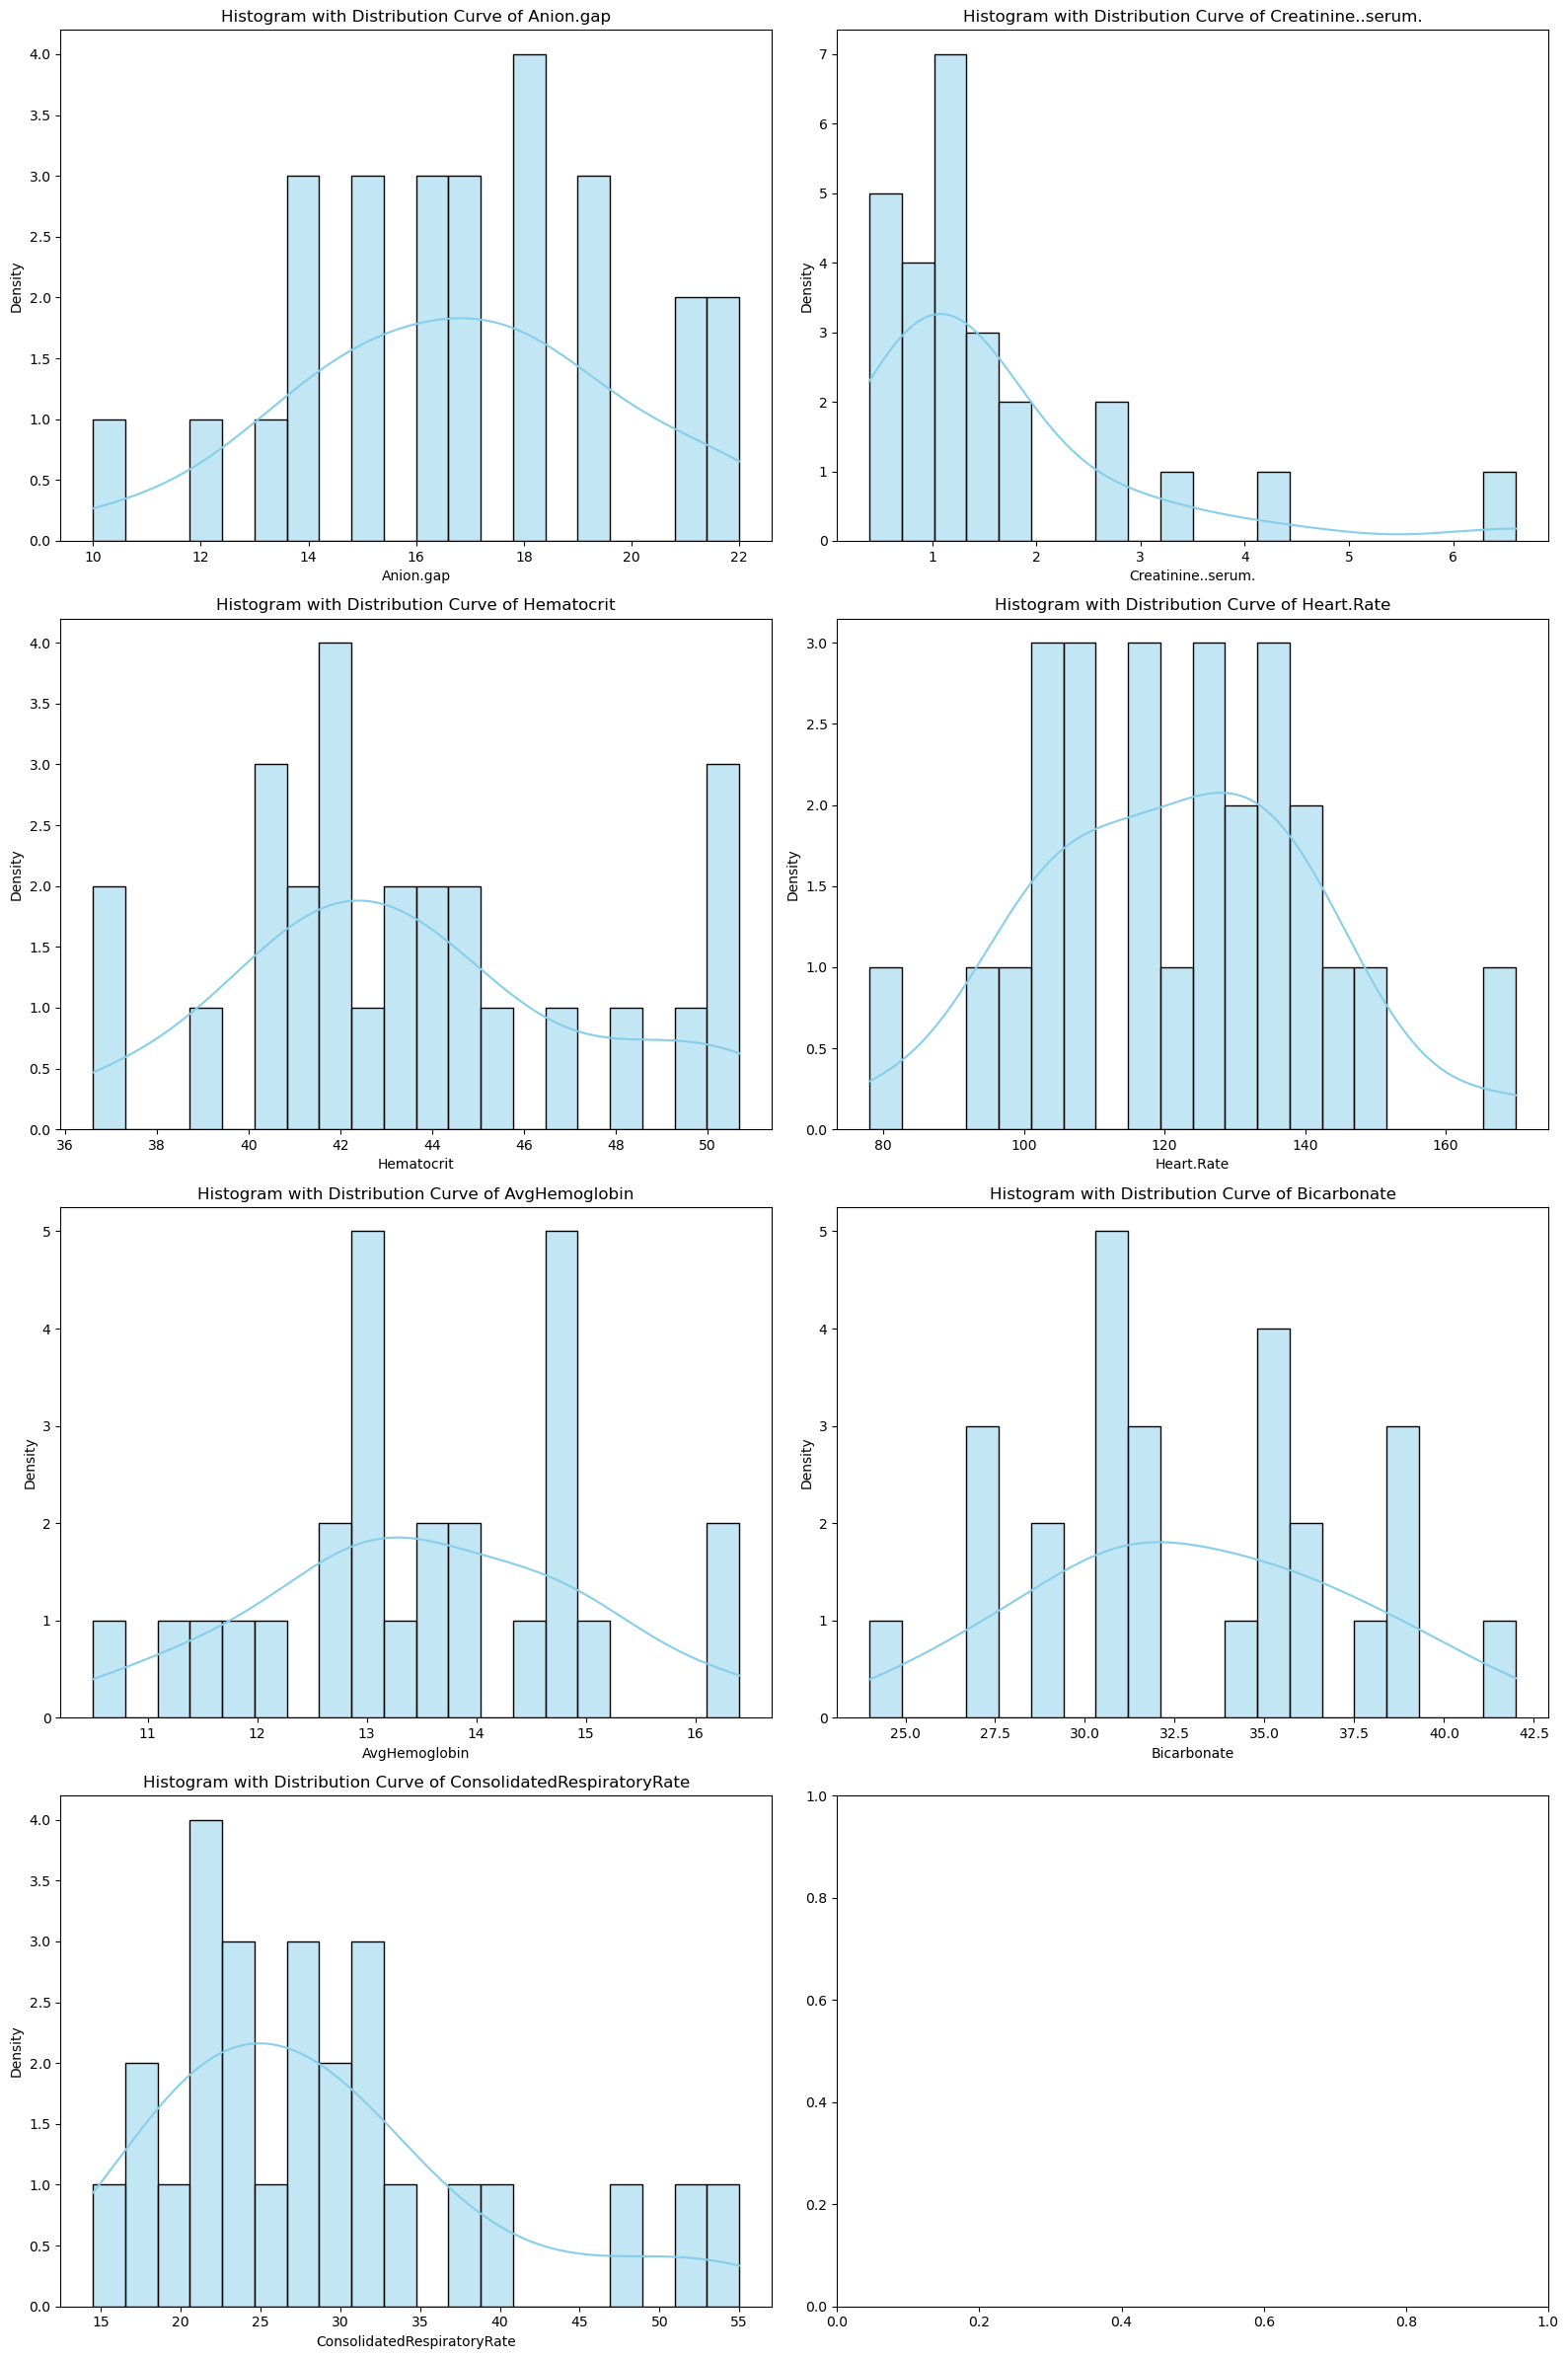

In [213]:
error_prediction_features = ['Anion.gap', 'Creatinine..serum.', 'Hematocrit', 'Heart.Rate', 'AvgHemoglobin', 'Bicarbonate', 'ConsolidatedRespiratoryRate']
num_features = len(error_prediction_features)
num_cols = 2
num_rows = math.ceil(num_features / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 6*num_rows))

for i, feature in enumerate(error_prediction_features):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(false_negatives[feature], kde=True, bins=20, color='skyblue', edgecolor='black', ax=axs[row, col])
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_title(f'Histogram with Distribution Curve of {feature}')

plt.tight_layout()
plt.show()
